## 🚦 Traffic Light Detection | Tensorflow


In [3]:
import re
import pathlib
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib import style
from tqdm import tqdm
from utils.all_path import AllPath
from utils.my_dataframe import MyDataFrame


In [4]:
style.use('ggplot')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


📦 Data Set:

- LISA Traffic Light Dataset - 🚀
- It has more than 44 minutes of annotated traffic light data.


## 1. Load Data


In [5]:
all_paths = AllPath()
all_paths

AllPath(_DATA_BASE_DIR=WindowsPath('raw_data'), _DATA_ANOTATIONs=WindowsPath('raw_data/Annotations/Annotations'), DATA_ANOTATIONs_DAY_TRAIN=WindowsPath('raw_data/Annotations/Annotations/dayTrain'), DATA_ANOTATIONs_NIGHT_TRAIN=WindowsPath('raw_data/Annotations/Annotations/nightTrain'), DATA_FILE_LOCATION_DAY_TRAIN=WindowsPath('raw_data/dayTrain/dayTrain'), DATA_FILE_LOCATION_NIGHT_TRAIN=WindowsPath('raw_data/nightTrain/nightTrain'))

In [6]:
day_train = []
night_train = []

for clip in tqdm(all_paths.DATA_ANOTATIONs_DAY_TRAIN.glob('*/')):
    df = pd.read_csv(pathlib.Path(clip) / 'frameAnnotationsBOX.csv', sep=';')
    day_train.append(df)


for clip in tqdm(all_paths.DATA_ANOTATIONs_NIGHT_TRAIN.glob('*/')):
    df = pd.read_csv(pathlib.Path(clip) / 'frameAnnotationsBOX.csv', sep=';')
    night_train.append(df)

df_day_train = pd.concat(day_train)
df_day_train['isNight'] = 0


df_night_train = pd.concat(night_train)
df_night_train['isNight'] = 1

df = pd.concat([df_day_train,df_night_train])
print('All Day and Night training data shap:',df.shape)
df.head()


13it [00:00, 67.69it/s]
5it [00:00, 42.01it/s]

All Day and Night training data shap: (51826, 11)


,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number,isNight
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0


## 2. Preprocessing


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51826 entries, 0 to 3235
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Filename                   51826 non-null  object
 1   Annotation tag             51826 non-null  object
 2   Upper left corner X        51826 non-null  int64 
 3   Upper left corner Y        51826 non-null  int64 
 4   Lower right corner X       51826 non-null  int64 
 5   Lower right corner Y       51826 non-null  int64 
 6   Origin file                51826 non-null  object
 7   Origin frame number        51826 non-null  int64 
 8   Origin track               51826 non-null  object
 9   Origin track frame number  51826 non-null  int64 
 10  isNight                    51826 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 4.7+ MB


In [8]:
# drop duplicate columns
df = (
    df
    .T # transpose 
    .drop_duplicates() # drop duplicate rows
    .T # transpose back again
    )
df

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,isNight
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0
...,...,...,...,...,...,...,...,...,...
3231,nightTraining/nightClip5--01450.jpg,go,937,221,976,290,nightTraining/nightClip5/clip5.mp4,1450,1
3232,nightTraining/nightClip5--01451.jpg,go,467,36,512,117,nightTraining/nightClip5/clip5.mp4,1451,1
3233,nightTraining/nightClip5--01451.jpg,go,937,219,976,288,nightTraining/nightClip5/clip5.mp4,1451,1
3234,nightTraining/nightClip5--01452.jpg,go,460,33,506,114,nightTraining/nightClip5/clip5.mp4,1452,1


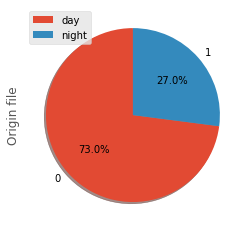

In [9]:
(
    df
    .groupby(by='isNight')
    .count()
    ['Origin file']
    .plot.pie(autopct='%1.1f%%',shadow=True,startangle=90)
)
plt.legend(['day', 'night'])

In [10]:
df['Filename']

0           dayTraining/dayClip1--00000.jpg
1           dayTraining/dayClip1--00000.jpg
2           dayTraining/dayClip1--00001.jpg
3           dayTraining/dayClip1--00001.jpg
4           dayTraining/dayClip1--00002.jpg
                       ...                 
3231    nightTraining/nightClip5--01450.jpg
3232    nightTraining/nightClip5--01451.jpg
3233    nightTraining/nightClip5--01451.jpg
3234    nightTraining/nightClip5--01452.jpg
3235    nightTraining/nightClip5--01452.jpg
Name: Filename, Length: 51826, dtype: object

In [11]:
def changFileName(x):
    """
    An helper function to change file name 
    i.e. 
    dayTraining/dayClip1--00000.jpg -> 
    dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg
    """

    
    file_name = re.findall("^.*/(.*)",x.Filename)[0]
    dayClip = file_name.split('--')[0]
    
    if x.isNight == 1:
        return str(all_paths.DATA_FILE_LOCATION_NIGHT_TRAIN \
            / dayClip \
            / 'frames' \
            / file_name)
    
    elif x.isNight == 0:
        return str(all_paths.DATA_FILE_LOCATION_DAY_TRAIN \
            / dayClip \
            / 'frames' \
            / file_name)


df['CorrectFileLocation'] = df.apply(changFileName,axis=1)
df


,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,isNight,CorrectFileLocation
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0,raw_data\dayTrain\dayTrain\dayClip1\frames\day...
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0,raw_data\dayTrain\dayTrain\dayClip1\frames\day...
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0,raw_data\dayTrain\dayTrain\dayClip1\frames\day...
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0,raw_data\dayTrain\dayTrain\dayClip1\frames\day...
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0,raw_data\dayTrain\dayTrain\dayClip1\frames\day...
...,...,...,...,...,...,...,...,...,...,...
3231,nightTraining/nightClip5--01450.jpg,go,937,221,976,290,nightTraining/nightClip5/clip5.mp4,1450,1,raw_data\nightTrain\nightTrain\nightClip5\fram...
3232,nightTraining/nightClip5--01451.jpg,go,467,36,512,117,nightTraining/nightClip5/clip5.mp4,1451,1,raw_data\nightTrain\nightTrain\nightClip5\fram...
3233,nightTraining/nightClip5--01451.jpg,go,937,219,976,288,nightTraining/nightClip5/clip5.mp4,1451,1,raw_data\nightTrain\nightTrain\nightClip5\fram...
3234,nightTraining/nightClip5--01452.jpg,go,460,33,506,114,nightTraining/nightClip5/clip5.mp4,1452,1,raw_data\nightTrain\nightTrain\nightClip5\fram...


## data analysis


Text(0, 0.5, '')

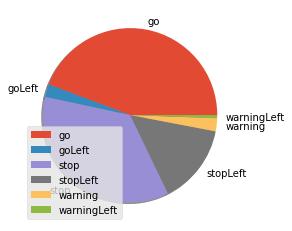

In [12]:
# plot the annotation distribution
(
    df.
    groupby('Annotation tag').
    count()['Origin file'].
    plot.
    pie(shadow=True)
)


plt.legend(
    df.
    groupby('Annotation tag').
    count()['Origin file'].index
    )
plt.ylabel('')


In [13]:
# create label
labels = {'go':0, 'warning':1, 'stop': 2}


df['Annotation tag'].apply(lambda x :0 if 'go' in x else x)

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return labels['go']
    elif 'warning' in x['Annotation tag']:
        return labels['warning']
    elif 'stop' in x['Annotation tag']:
        return labels['stop']

df['label'] = df.apply(changeAnnotation,axis=1)
df


,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,isNight,CorrectFileLocation,label
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,0
...,...,...,...,...,...,...,...,...,...,...,...
3231,nightTraining/nightClip5--01450.jpg,go,937,221,976,290,nightTraining/nightClip5/clip5.mp4,1450,1,raw_data\nightTrain\nightTrain\nightClip5\fram...,0
3232,nightTraining/nightClip5--01451.jpg,go,467,36,512,117,nightTraining/nightClip5/clip5.mp4,1451,1,raw_data\nightTrain\nightTrain\nightClip5\fram...,0
3233,nightTraining/nightClip5--01451.jpg,go,937,219,976,288,nightTraining/nightClip5/clip5.mp4,1451,1,raw_data\nightTrain\nightTrain\nightClip5\fram...,0
3234,nightTraining/nightClip5--01452.jpg,go,460,33,506,114,nightTraining/nightClip5/clip5.mp4,1452,1,raw_data\nightTrain\nightTrain\nightClip5\fram...,0


Text(0, 0.5, '')

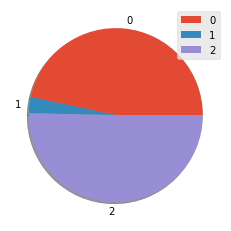

In [14]:
(
    df.
    groupby('label').
    count()['Origin file'].
    plot.
    pie(shadow=True)
)


plt.legend(
    df.
    groupby('label').
    count()['Origin file'].index
    )

plt.ylabel('')

In [15]:
# Get needed information only
dataset = df[[
       'CorrectFileLocation', 
       'Upper left corner X',
       'Upper left corner Y', 
       'Lower right corner X', 
       'Lower right corner Y',
       'Origin frame number', 
       'isNight',
       'label'
]]

# rename columns
(
       dataset.rename(
              {
                  'CorrectFileLocation' : 'image_id',
                     'Upper left corner X': 'x_min',
                     'Upper left corner Y':'y_min', 
                     'Lower right corner X':'x_max', 
                     'Lower right corner Y':'y_max',
                     'Origin frame number':'frame', 
              }
       ,axis=1
       ,inplace=True
       )
)

# Add Clip column 

dataset.head()

c:\Users\Noel\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,image_id,x_min,y_min,x_max,y_max,frame,isNight,label
0,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,698,333,710,358,0,0,0
1,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,846,391,858,411,0,0,0
2,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,698,337,710,357,1,0,0
3,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,847,390,859,410,1,0,0
4,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,698,331,710,356,2,0,0


## Exploratory Data Analysis


In [16]:
print("Number of Unique Images: ",dataset.image_id.nunique(),'/',df.shape[0])

Number of Unique Images:  18013 / 51826


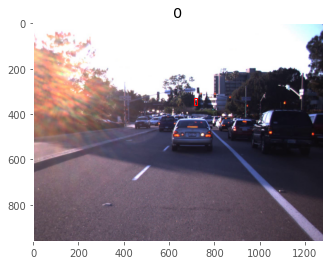

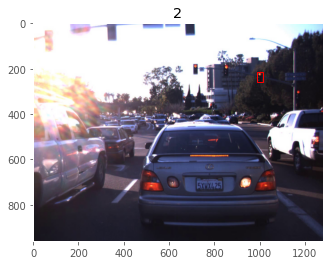

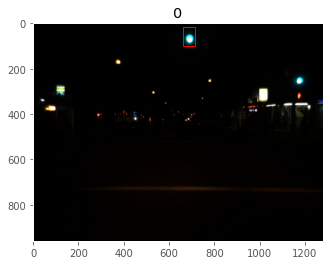

In [17]:
MyDataFrame(dataset).plotDetection(334)
MyDataFrame(dataset).plotDetection(3333)
MyDataFrame(dataset).plotDetection(45555)

# Create Train and Validation dataset
1. Collect and annotate a dataset of images and their corresponding bounding box labels. You can use a tool like LabelImg to draw bounding boxes around the objects in your images and save the labels in the correct format for YOLO.

2. Use the YOLO command line tool to convert the annotated images and labels into the format that YOLO expects. This typically involves creating a file that lists the paths to the images and labels, and then running a command to generate the training data in the correct format.




In [18]:
image_id = dataset.image_id
bounding_box = dataset[['x_min', 'y_min','x_max','y_max']].astype(float)
bounding_box['x_min'] = bounding_box['x_min'] / 1280
bounding_box['y_min'] = bounding_box['y_min'] / 960
bounding_box['x_max'] = bounding_box['x_max'] / 1280
bounding_box['y_max'] = bounding_box['y_max'] / 960
label = tf.keras.utils.to_categorical(dataset['label'],num_classes=3,dtype='float') 
bounding_box

,x_min,y_min,x_max,y_max
0,0.545312,0.346875,0.554688,0.372917
1,0.660937,0.407292,0.670312,0.428125
2,0.545312,0.351042,0.554688,0.371875
3,0.661719,0.406250,0.671094,0.427083
4,0.545312,0.344792,0.554688,0.370833
...,...,...,...,...
3231,0.732031,0.230208,0.762500,0.302083
3232,0.364844,0.037500,0.400000,0.121875
3233,0.732031,0.228125,0.762500,0.300000
3234,0.359375,0.034375,0.395313,0.118750


In [19]:
def load_and_preprocess_image(image_id, label):
    image = tf.io.read_file(image_id)
    image = tf.image.decode_image(image,dtype=np.float32)
    image = image / 255.0
    return image,  label



tf_dataset = tf.data.Dataset.from_tensor_slices((image_id,(bounding_box,label)))

tf_dataset = tf_dataset.map(load_and_preprocess_image).batch(2)

tf_dataset

<BatchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), (TensorSpec(shape=(None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None)))>

In [20]:
#shared weight
vgg = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False,input_tensor=tf.keras.layers.Input(shape=(960, 1280, 3)))
vgg.trainable = False
flatten = tf.keras.layers.Flatten()(vgg.output)

# Bouding box 
bboxHead = tf.keras.layers.Dense(128, activation='relu')(flatten)
bboxHead = tf.keras.layers.Dense(64, activation='relu')(bboxHead)
bboxHead = tf.keras.layers.Dense(32, activation='relu')(bboxHead)
bboxHead = tf.keras.layers.Dense(4, activation='sigmoid', name='bounding_box')(bboxHead)

# class 
softmaxHead = tf.keras.layers.Dense(256, activation='relu')(flatten)
softmaxHead = tf.keras.layers.Dropout(0.5)(softmaxHead)
softmaxHead = tf.keras.layers.Dense(128, activation='relu')(softmaxHead)
softmaxHead = tf.keras.layers.Dropout(0.5)(softmaxHead)
softmaxHead = tf.keras.layers.Dense(3, activation='softmax', name='class_label')(softmaxHead)  


model = tf.keras.Model(
    inputs=vgg.input,
    outputs=(bboxHead, softmaxHead)
    )

lossWeights = {
    'class_label': 1.0,
    'bounding_box': 1.0
}
losses = {
    'class_label': 'categorical_crossentropy',
    'bounding_box': 'mean_squared_error',
}

model.compile(loss=losses, 
              optimizer='adam', 
              metrics=["accuracy"], 
              loss_weights=lossWeights)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 960, 1280,   0           []                               
                                3)]                                                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 960, 1280, 6  1792        ['input_1[0][0]']                
                                4)                                                                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 960, 1280, 6  36928       ['block1_conv1[0][0]']           
                                4)                                                            

In [21]:
history = model.fit(tf_dataset,batch_size=2)

: 

: 


# Alternatively, use YOLOv5

In [16]:
x_center = (dataset['x_min'] + dataset['x_max'])/2
y_center = (dataset['y_min'] + dataset['y_max'])/2
width = dataset['x_max'] - dataset['x_min']
height  = dataset['y_max'] - dataset['y_min']

dataset['x_center'] = x_center / 1280
dataset['y_center'] = y_center / 960
dataset['width'] = width / 1280
dataset['height'] = height / 960

dataset['txt'] = dataset['label'].astype(str) + ' ' \
    + dataset['x_center'].astype(str) + ' ' \
    + dataset['y_center'].astype(str) + ' ' \
    + dataset['width'].astype(str) + ' ' \
    + dataset['height'].astype(str)

dataset['filename'] = dataset.image_id.str.split('\\').apply(lambda x:x[-1])

dataset

C:\Users\Noel\AppData\Local\Temp/ipykernel_9960/1329710816.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['x_center'] = x_center / 1280
C:\Users\Noel\AppData\Local\Temp/ipykernel_9960/1329710816.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['y_center'] = y_center / 960


,image_id,x_min,y_min,x_max,y_max,frame,isNight,label,x_center,y_center,width,height,txt,filename
0,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,698,333,710,358,0,0,0,0.55,0.359896,0.009375,0.026042,0 0.55 0.35989583333333336 0.009375 0.02604166...,dayClip1--00000.jpg
1,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,846,391,858,411,0,0,0,0.665625,0.417708,0.009375,0.020833,0 0.665625 0.41770833333333335 0.009375 0.0208...,dayClip1--00000.jpg
2,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,698,337,710,357,1,0,0,0.55,0.361458,0.009375,0.020833,0 0.55 0.3614583333333333 0.009375 0.020833333...,dayClip1--00001.jpg
3,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,847,390,859,410,1,0,0,0.666406,0.416667,0.009375,0.020833,0 0.66640625 0.4166666666666667 0.009375 0.020...,dayClip1--00001.jpg
4,raw_data\dayTrain\dayTrain\dayClip1\frames\day...,698,331,710,356,2,0,0,0.55,0.357812,0.009375,0.026042,0 0.55 0.3578125 0.009375 0.026041666666666668,dayClip1--00002.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,raw_data\nightTrain\nightTrain\nightClip5\fram...,937,221,976,290,1450,1,0,0.747266,0.266146,0.030469,0.071875,0 0.747265625 0.26614583333333336 0.03046875 0...,nightClip5--01450.jpg
3232,raw_data\nightTrain\nightTrain\nightClip5\fram...,467,36,512,117,1451,1,0,0.382422,0.079687,0.035156,0.084375,0 0.382421875 0.0796875 0.03515625 0.084375,nightClip5--01451.jpg
3233,raw_data\nightTrain\nightTrain\nightClip5\fram...,937,219,976,288,1451,1,0,0.747266,0.264062,0.030469,0.071875,0 0.747265625 0.2640625 0.03046875 0.071875,nightClip5--01451.jpg
3234,raw_data\nightTrain\nightTrain\nightClip5\fram...,460,33,506,114,1452,1,0,0.377344,0.076563,0.035937,0.084375,0 0.37734375 0.0765625 0.0359375 0.084375,nightClip5--01452.jpg


In [17]:
val_data = dataset[dataset.image_id.str.contains('dayClip1') | dataset.image_id.str.contains('nightClip5')]
train_data = dataset[~dataset.image_id.str.contains('dayClip1') | dataset.image_id.str.contains('nightClip5')]
print(f'Valiation data shape is: {val_data.shape}, training data shape is: {train_data.shape}')


Valiation data shape is: (14090, 14), training data shape is: (40972, 14)


In [18]:
class TrainValidationGen:
    
    
    def __init__(self,train_data,val_data,base_dir = pathlib.Path('datasets')) -> None:
        self.train_data = train_data
        self.val_data = val_data  
        self.train_img_dir = base_dir / 'images' / 'training'
        self.val_img_dir = base_dir / 'images' / 'validation'
        self.train_label_dir = base_dir / 'labels' / 'training'
        self.val_label_dir = base_dir / 'labels' / 'validation'


    def _write_txt(self):
        
        for i, row in self.train_data.iterrows():
            with open(str(self.train_label_dir /( row.filename.split('.')[0] + '.txt')), 'w') as f:
                f.write(row.txt)
    
        for i, row in self.val_data.iterrows():
            with open(str(self.val_label_dir /( row.filename.split('.')[0] + '.txt')), 'w') as f:
                f.write(row.txt)

        

    def __call__(self): 
        self.train_img_dir.mkdir(parents=True, exist_ok=True)
        self.val_img_dir.mkdir(parents=True, exist_ok=True)
        self.train_label_dir.mkdir(parents=True, exist_ok=True)
        self.val_label_dir.mkdir(parents=True, exist_ok=True)
        self._write_txt()
        self.train_data.image_id.apply(lambda x: shutil.copy(x, self.train_img_dir / x.split('\\')[-1]))
        self.val_data.image_id.apply(lambda x: shutil.copy(x, self.val_img_dir / x.split('\\')[-1]))

        print('Data generate done ')



dataset_gen = TrainValidationGen(train_data,val_data)
dataset_gen()

KeyboardInterrupt: 

In [ ]:
print(len(list(dataset_gen.train_img_dir.iterdir())) == len(list(dataset_gen.train_label_dir.iterdir())))
print(len(list(dataset_gen.val_img_dir.iterdir()))==len(list(dataset_gen.val_label_dir.iterdir())))


True
True


In [ ]:
# ! python yolov5/train.py --img 640 --batch 12 --epochs 1 --data utils/dataset.yaml --weights yolov5s.pt --workers 1 

# Train the model

In [ ]:
def load_image(image_path):
    # Read the image file
    image_string = tf.io.read_file(image_path)
    # Decode the image and return it as a tensor
    image = tf.image.decode_image(image_string)
    return image

load_image(dataset_gen.train_img_dir)

ValueError: Attempt to convert a value (WindowsPath('datasets/images/training')) with an unsupported type (<class 'pathlib.WindowsPath'>) to a Tensor.